Name : Prashant Gupta <br>
Roll Number : 2020102030

In [1]:
import nilearn
nilearn.__version__

from nilearn import plotting

In [2]:
import warnings
warnings.simplefilter("ignore") 

In [3]:
from nilearn.datasets import fetch_miyawaki2008
import matplotlib.pyplot as plt
dataset = fetch_miyawaki2008()

# Training the Decoder on Alphabets and Shapes Combined

In [4]:
fmri_shape_runs_filenames = dataset.func[0:12:]
stimuli_shape_runs_filenames = dataset.label[0:12:]

In [5]:
import numpy as np
from nilearn.maskers import MultiNiftiMasker

masker = MultiNiftiMasker(mask_img=dataset.mask, detrend=True,
                          standardize=True)
masker.fit()
fmri_data_shapes = masker.transform(fmri_shape_runs_filenames)

# shape of the binary (i.e. black and wihte values) image in pixels
stimulus_shape = (10, 10)

# We load the visual stimuli from csv files
stimuli = []
for stimulus_run in stimuli_shape_runs_filenames:
    stimuli.append(np.reshape(np.loadtxt(stimulus_run,dtype=int, delimiter=','),(-1,) + stimulus_shape, order='F'))

In [6]:
fmri_data = np.vstack([fmri_run[2:] for fmri_run in fmri_data_shapes])
stimuli = np.vstack([stimuli_run[:-2] for stimuli_run in stimuli]).astype(float)

In [7]:
stimuli = np.reshape(stimuli, (-1, stimulus_shape[0] * stimulus_shape[1]))

In [8]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

In [9]:
from sklearn.metrics import r2_score

estimator = Ridge(alpha=100.)
cv = KFold(n_splits=10)

scores = []
for train, test in cv.split(X=stimuli):
    # we train the Ridge estimator on the training set
    # and predict the fMRI activity for the test set
    predictions = Ridge(alpha=100.).fit(
    stimuli.reshape(-1, 100)[train], fmri_data[train]).predict(
        stimuli.reshape(-1, 100)[test])
    # we compute how much variance our encoding model explains in each voxel
    scores.append(r2_score(fmri_data[test], predictions,
                           multioutput='raw_values'))

In [10]:
from nilearn.image import threshold_img
cut_score = np.mean(scores, axis=0)
cut_score[cut_score < 0] = 0

# bring the scores into the shape of the background brain
score_map_img = masker.inverse_transform(cut_score)

thresholded_score_map_img = threshold_img(score_map_img, threshold=1e-6, copy=False)

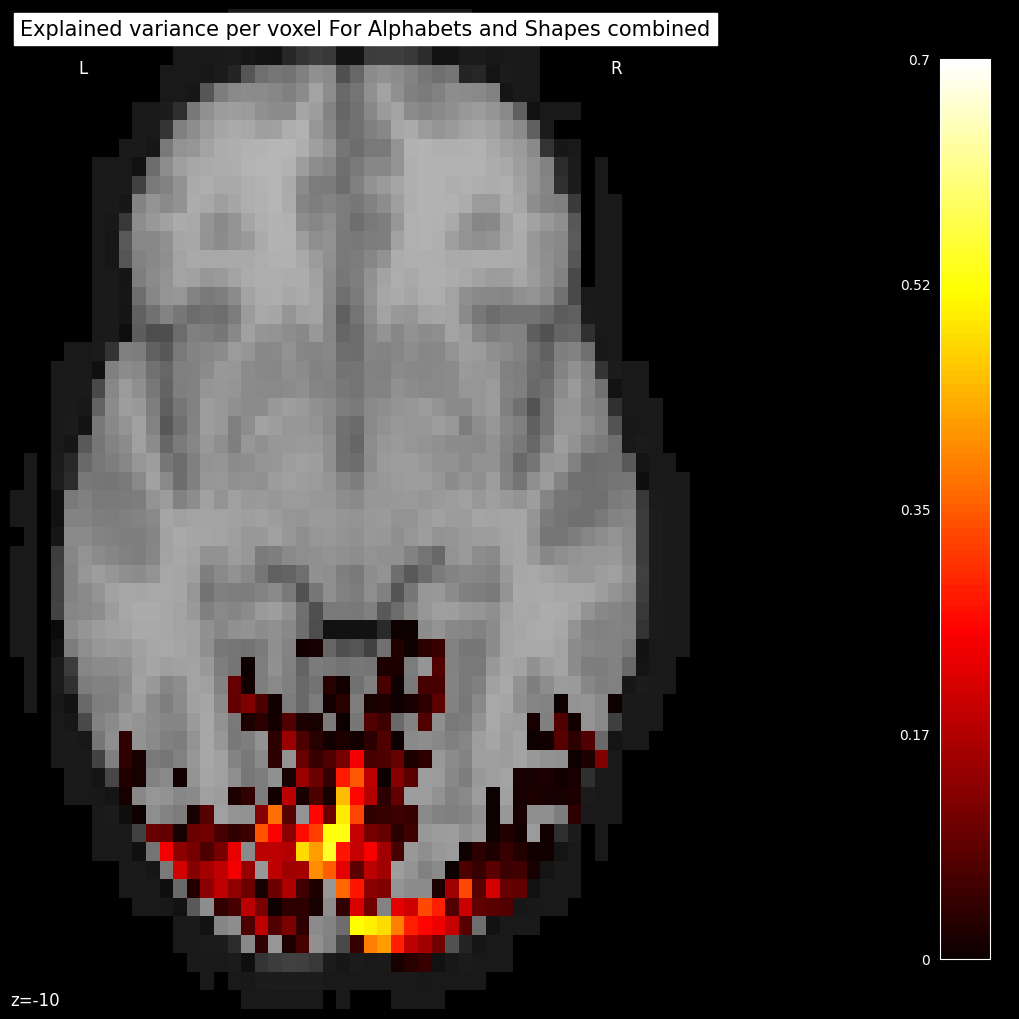

In [11]:
from nilearn.plotting import plot_stat_map

display = plot_stat_map(thresholded_score_map_img, bg_img=dataset.background,
                        cut_coords=[-10], display_mode='z', aspect=1.25,
                        title='Explained variance per voxel For Alphabets and Shapes combined')
# re-set figure size after construction so colorbar gets rescaled too
fig = plt.gcf()
fig.set_size_inches(10, 10)

In [12]:
top_four_indices = cut_score.argsort()[::-1][:4]
print("Top R_score voxels are ",top_four_indices)

Top R_score voxels are  [1922 2251 1424 1588]


In [13]:
top_index1 = top_four_indices[0]
top_index2 = top_four_indices[1]
top_index3 = top_four_indices[2]
top_index4 = top_four_indices[3]

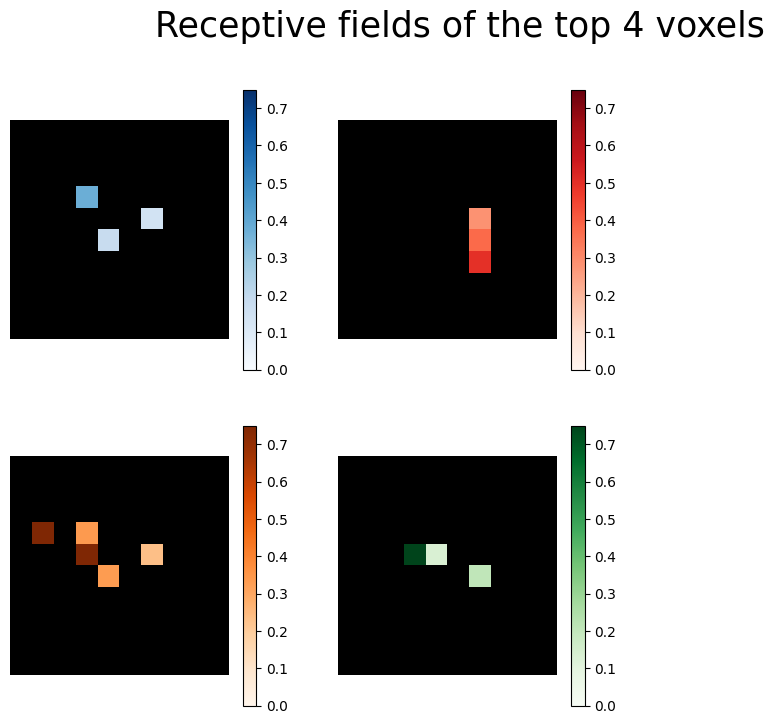

In [14]:
from sklearn.linear_model import LassoLarsCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# automatically estimate the sparsity by cross-validation

lasso = make_pipeline(StandardScaler(),
                      LassoLarsCV(normalize=False, max_iter=10))

from matplotlib import gridspec
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(12, 8))
fig.suptitle('Receptive fields of the top 4 voxels', fontsize=25)

gs1 = gridspec.GridSpec(2, 3)

# Top most voxel
ax = plt.subplot(gs1[0,0])
lasso.fit(stimuli,fmri_data[:,top_index1])
rf = lasso.named_steps['lassolarscv'].coef_.reshape((10, 10))
ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                  cmap='Blues', vmin=0., vmax=0.75)
plt.axis('off')
plt.colorbar(ax_im, ax=ax)

# Second highest voxel
ax = plt.subplot(gs1[0,1])
lasso.fit(stimuli,fmri_data[:,top_index2])
rf = lasso.named_steps['lassolarscv'].coef_.reshape((10, 10))
ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                  cmap='Reds', vmin=0., vmax=0.75)
plt.axis('off')
plt.colorbar(ax_im, ax=ax)


# Third highest voxel
ax = plt.subplot(gs1[1,0])
lasso.fit(stimuli,fmri_data[:,top_index3])
rf = lasso.named_steps['lassolarscv'].coef_.reshape((10, 10))
ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                  cmap='Oranges', vmin=0., vmax=0.75)
plt.axis('off')
plt.colorbar(ax_im, ax=ax)


# Fourth highest voxel
ax = plt.subplot(gs1[1,1])
lasso.fit(stimuli,fmri_data[:,top_index4])
rf = lasso.named_steps['lassolarscv'].coef_.reshape((10, 10))
ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                  cmap='Greens', vmin=0., vmax=0.75)
plt.axis('off')
plt.colorbar(ax_im, ax=ax)

### Observations

From the above receptive fields we can observe that :
<ol>
    <li> The top most voxel is used to encode the pattern with the crossed pattern as shown in Blue colour mostly for multiplication symbol </li>
    <li> The second highest score voxel is encoding the vertical pattern (or) straight lines </li>
    <li> The third voxel is encoding a combination of horizontal line and a random pattern which could be used to decode the shapes of Multiplication and alphabets such as 'e' </li>
    <li> The fourth voxel is encoding primarily the horizontal lines as can be seen in green colour </li> 
</ol>

# Training the decoder on Shapes and Alphabets separately (Extra)

In [15]:
fmri_shapes_filenames = dataset.func[0:4:]
fmri_alphabets_filenames = dataset.func[4:12:]
stimuli_shapes_filenames = dataset.label[0:4:]
stimuli_alphabets_filenames = dataset.label[4:12:]

In [16]:
import numpy as np
from nilearn.maskers import MultiNiftiMasker

masker = MultiNiftiMasker(mask_img=dataset.mask, detrend=True,
                          standardize=True)
masker.fit()
fmri_data_shapes = masker.transform(fmri_shapes_filenames)

# shape of the binary (i.e. black and wihte values) image in pixels
stimulus_shape = (10, 10)

# We load the visual stimuli from csv files
stimuli_shapes = []
for stimulus_run in stimuli_shapes_filenames:
    stimuli_shapes.append(np.reshape(np.loadtxt(stimulus_run,dtype=int, delimiter=','),(-1,) + stimulus_shape, order='F'))

In [17]:
import numpy as np
from nilearn.maskers import MultiNiftiMasker

masker = MultiNiftiMasker(mask_img=dataset.mask, detrend=True,
                          standardize=True)
masker.fit()
fmri_data_alphabets = masker.transform(fmri_alphabets_filenames)

# shape of the binary (i.e. black and wihte values) image in pixels
stimulus_shape = (10, 10)

# We load the visual stimuli from csv files
stimuli_alphabets = []
for stimulus_run in stimuli_alphabets_filenames:
    stimuli_alphabets.append(np.reshape(np.loadtxt(stimulus_run,dtype=int, delimiter=','),(-1,) + stimulus_shape, order='F'))

In [18]:
fmri_data_alphabets = np.vstack([fmri_run[2:] for fmri_run in fmri_data_alphabets])
fmri_data_shapes = np.vstack([fmri_run[2:] for fmri_run in fmri_data_shapes])
stimuli_alphabets = np.vstack([stimuli_run[:-2] for stimuli_run in stimuli_alphabets]).astype(float)
stimuli_shapes = np.vstack([stimuli_run[:-2] for stimuli_run in stimuli_shapes]).astype(float)

In [19]:
stimuli_alphabets = np.reshape(stimuli_alphabets, (-1, stimulus_shape[0] * stimulus_shape[1]))
stimuli_shapes = np.reshape(stimuli_shapes, (-1, stimulus_shape[0] * stimulus_shape[1]))
print(stimuli_alphabets.shape)
print(stimuli_shapes.shape)

(1024, 100)
(512, 100)


In [20]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

In [21]:
from sklearn.metrics import r2_score

estimator = Ridge(alpha=100.)
cv = KFold(n_splits=10)

scores_alphabets = []
for train, test in cv.split(X=stimuli_alphabets):
    # we train the Ridge estimator on the training set
    # and predict the fMRI activity for the test set
    predictions = Ridge(alpha=100.).fit(
    stimuli_alphabets.reshape(-1, 100)[train], fmri_data_alphabets[train]).predict(
        stimuli_alphabets.reshape(-1, 100)[test])
    # we compute how much variance our encoding model explains in each voxel
    scores_alphabets.append(r2_score(fmri_data_alphabets[test], predictions,
                           multioutput='raw_values'))

In [22]:
from sklearn.metrics import r2_score

estimator = Ridge(alpha=100.)
cv = KFold(n_splits=10)

scores_shapes = []
for train, test in cv.split(X=stimuli_shapes):
    # we train the Ridge estimator on the training set
    # and predict the fMRI activity for the test set
    predictions = Ridge(alpha=100.).fit(
    stimuli_shapes.reshape(-1, 100)[train], fmri_data_shapes[train]).predict(
        stimuli_shapes.reshape(-1, 100)[test])
    # we compute how much variance our encoding model explains in each voxel
    scores_shapes.append(r2_score(fmri_data_shapes[test], predictions,
                           multioutput='raw_values'))

In [23]:
from nilearn.image import threshold_img
cut_score_alphabets = np.mean(scores_alphabets, axis=0)
cut_score_alphabets[cut_score_alphabets < 0] = 0

# bring the scores into the shape of the background brain
score_map_img_alphabets = masker.inverse_transform(cut_score_alphabets)

thresholded_score_map_img_alphabets = threshold_img(score_map_img_alphabets, threshold=1e-6, copy=False)

In [24]:
from nilearn.image import threshold_img
cut_score_shapes = np.mean(scores_shapes, axis=0)
cut_score_shapes[cut_score_shapes < 0] = 0

# bring the scores into the shape of the background brain
score_map_img_shapes = masker.inverse_transform(cut_score_shapes)

thresholded_score_map_img_shapes = threshold_img(score_map_img_shapes, threshold=1e-6, copy=False)

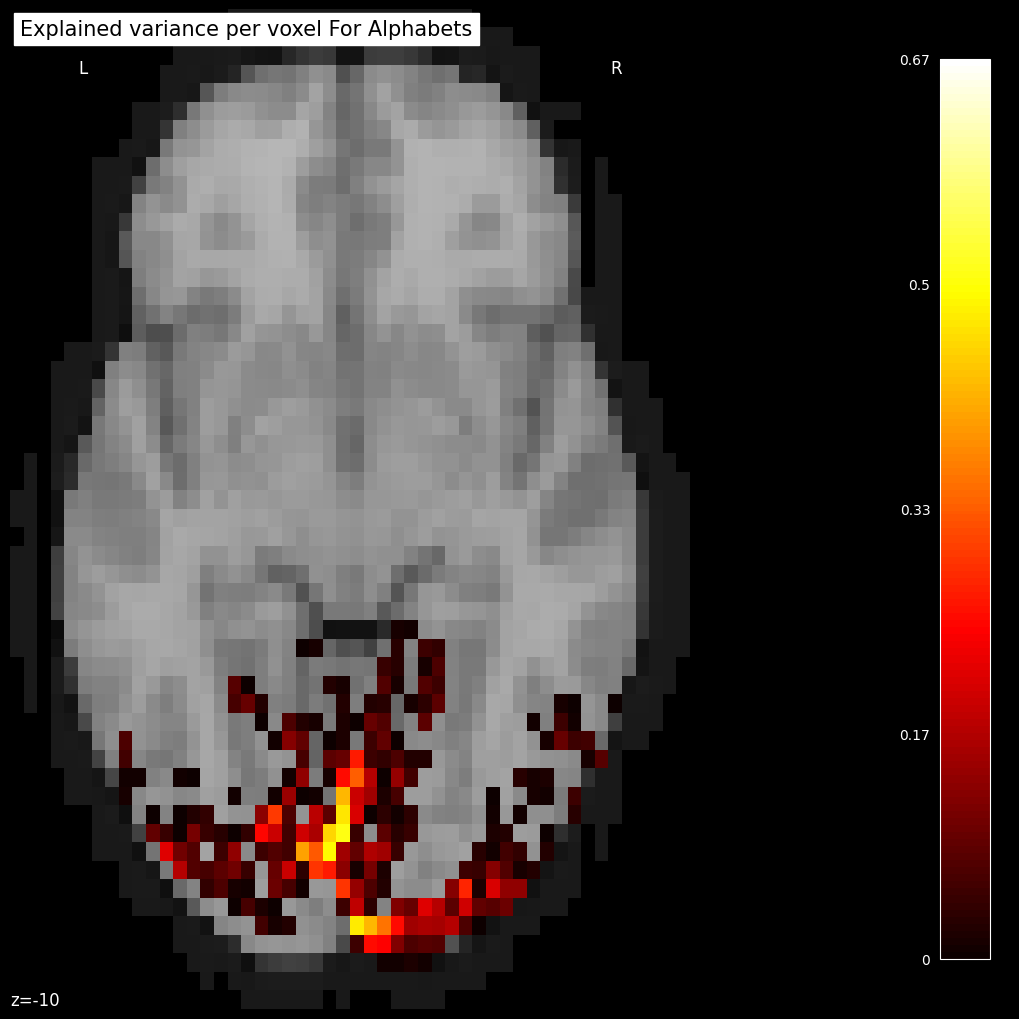

In [25]:
from nilearn.plotting import plot_stat_map

display = plot_stat_map(thresholded_score_map_img_alphabets, bg_img=dataset.background,
                        cut_coords=[-10], display_mode='z', aspect=1.25,
                        title='Explained variance per voxel For Alphabets')
# re-set figure size after construction so colorbar gets rescaled too
fig = plt.gcf()
fig.set_size_inches(10, 10)

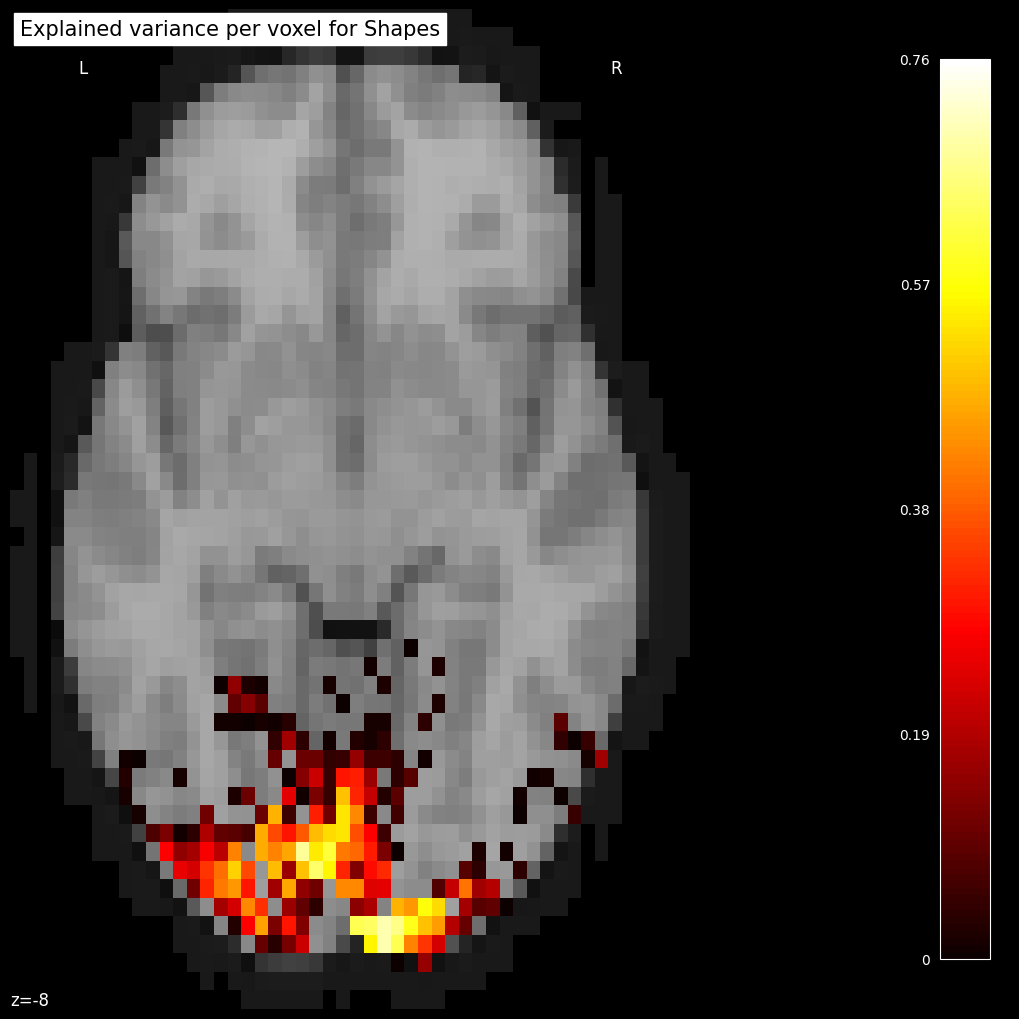

In [26]:
from nilearn.plotting import plot_stat_map

display = plot_stat_map(thresholded_score_map_img_shapes, bg_img=dataset.background,
                        cut_coords=[-8], display_mode='z', aspect=1.25,
                        title='Explained variance per voxel for Shapes')
# re-set figure size after construction so colorbar gets rescaled too
fig = plt.gcf()
fig.set_size_inches(10, 10)

In [27]:
top_four_indices_shapes = cut_score_shapes.argsort()[::-1][:4]
top_four_indices_alphabets = cut_score_alphabets.argsort()[::-1][:4]

In [28]:
top_shape1 = top_four_indices_shapes[0]
top_shape2 = top_four_indices_shapes[1]
top_shape3 = top_four_indices_shapes[2]
top_shape4 = top_four_indices_shapes[3]

In [29]:
top_alphabets1 = top_four_indices_alphabets[0]
top_alphabets2 = top_four_indices_alphabets[1]
top_alphabets3 = top_four_indices_alphabets[2]
top_alphabets4 = top_four_indices_alphabets[3]

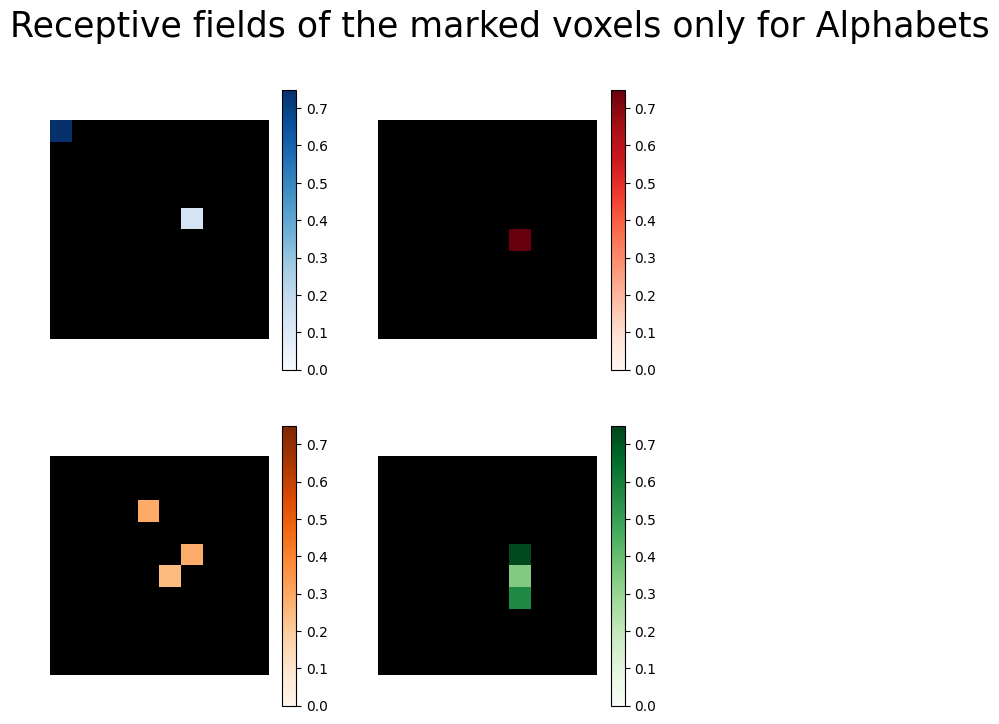

In [30]:
from sklearn.linear_model import LassoLarsCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# automatically estimate the sparsity by cross-validation

lasso = make_pipeline(StandardScaler(),
                      LassoLarsCV(normalize=False, max_iter=10))

from matplotlib import gridspec
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(12, 8))
fig.suptitle('Receptive fields of the marked voxels only for Alphabets', fontsize=25)

gs1 = gridspec.GridSpec(2, 3)

# Top most voxel
ax = plt.subplot(gs1[0,0])
lasso.fit(stimuli_alphabets,fmri_data_alphabets[:,top_alphabets1])
rf = lasso.named_steps['lassolarscv'].coef_.reshape((10, 10))
ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                  cmap='Blues', vmin=0., vmax=0.75)
plt.axis('off')
plt.colorbar(ax_im, ax=ax)

# Second highest voxel
ax = plt.subplot(gs1[0,1])
lasso.fit(stimuli_alphabets,fmri_data_alphabets[:,top_alphabets2])
rf = lasso.named_steps['lassolarscv'].coef_.reshape((10, 10))
ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                  cmap='Reds', vmin=0., vmax=0.75)
plt.axis('off')
plt.colorbar(ax_im, ax=ax)


# Third highest voxel
ax = plt.subplot(gs1[1,0])
lasso.fit(stimuli_alphabets,fmri_data_alphabets[:,top_alphabets3])
rf = lasso.named_steps['lassolarscv'].coef_.reshape((10, 10))
ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                  cmap='Oranges', vmin=0., vmax=0.75)
plt.axis('off')
plt.colorbar(ax_im, ax=ax)


# Fourth highest voxel
ax = plt.subplot(gs1[1,1])
lasso.fit(stimuli_alphabets,fmri_data_alphabets[:,top_alphabets4])
rf = lasso.named_steps['lassolarscv'].coef_.reshape((10, 10))
ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                  cmap='Greens', vmin=0., vmax=0.75)
plt.axis('off')
plt.colorbar(ax_im, ax=ax)

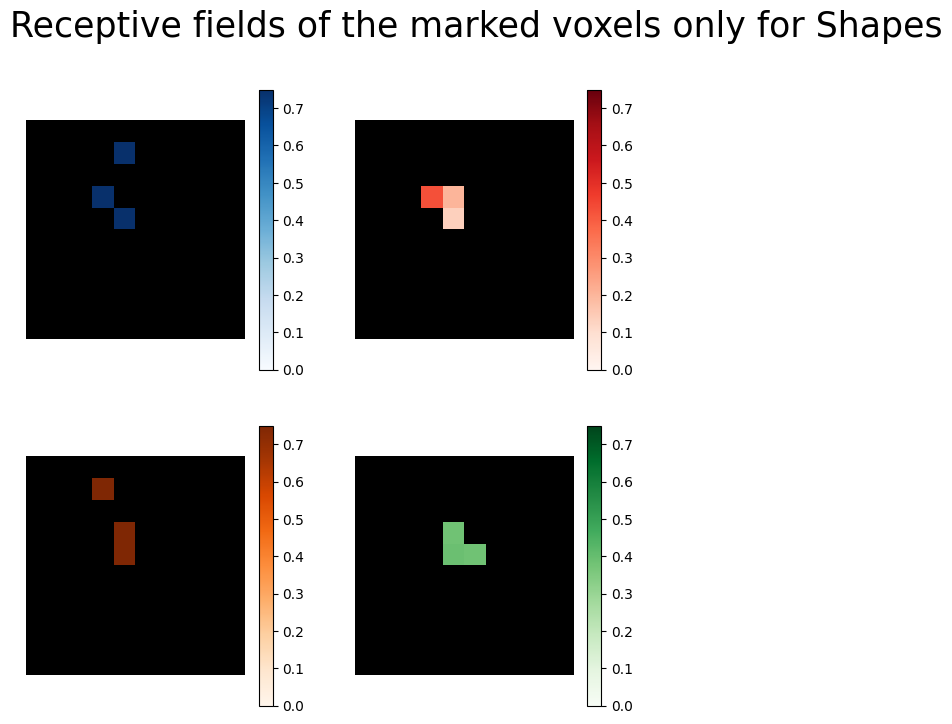

In [31]:
from sklearn.linear_model import LassoLarsCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# automatically estimate the sparsity by cross-validation

lasso = make_pipeline(StandardScaler(),
                      LassoLarsCV(normalize=False, max_iter=10))

from matplotlib import gridspec
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(12, 8))
fig.suptitle('Receptive fields of the marked voxels only for Shapes', fontsize=25)

gs1 = gridspec.GridSpec(2, 3)

# Top most voxel
ax = plt.subplot(gs1[0,0])
lasso.fit(stimuli_shapes,fmri_data_shapes[:,top_shape1])
rf = lasso.named_steps['lassolarscv'].coef_.reshape((10, 10))
ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                  cmap='Blues', vmin=0., vmax=0.75)
plt.axis('off')
plt.colorbar(ax_im, ax=ax)

# Second highest voxel
ax = plt.subplot(gs1[0,1])
lasso.fit(stimuli_shapes,fmri_data_shapes[:,top_shape2])
rf = lasso.named_steps['lassolarscv'].coef_.reshape((10, 10))
ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                  cmap='Reds', vmin=0., vmax=0.75)
plt.axis('off')
plt.colorbar(ax_im, ax=ax)


# Third highest voxel
ax = plt.subplot(gs1[1,0])
lasso.fit(stimuli_shapes,fmri_data_shapes[:,top_shape3])
rf = lasso.named_steps['lassolarscv'].coef_.reshape((10, 10))
ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                  cmap='Oranges', vmin=0., vmax=0.75)
plt.axis('off')
plt.colorbar(ax_im, ax=ax)


# Fourth highest voxel
ax = plt.subplot(gs1[1,1])
lasso.fit(stimuli_shapes,fmri_data_shapes[:,top_shape4])
rf = lasso.named_steps['lassolarscv'].coef_.reshape((10, 10))
ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                  cmap='Greens', vmin=0., vmax=0.75)
plt.axis('off')
plt.colorbar(ax_im, ax=ax)

